In [ ]:
# CSV 파일 불러오기
# for vs code
file_path1 = 'data/Meteorological_2019_01.csv'
file_path2 = 'data/서울시_대기질_2019_01.csv'
xtest_path = 'data/Meteorological_2020_01.csv'
ytest_path = 'data/서울시_대기질_2020_01.csv'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install scikeras

In [3]:

# CSV 파일 불러오기
# for google colab
file_path1 = '/content/drive/MyDrive/2024-2학기_연구참여/data/Meteorological_2019_01.csv'
file_path2 = '/content/drive/MyDrive/2024-2학기_연구참여/data/서울시_대기질_2019_01.csv'
xtest_path = '/content/drive/MyDrive/2024-2학기_연구참여/data/Meteorological_2020_01.csv'
ytest_path = '/content/drive/MyDrive/2024-2학기_연구참여/data/서울시_대기질_2020_01.csv'

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Lambda
from sklearn.model_selection import train_test_split, GridSearchCV
from scikeras.wrappers import KerasRegressor

In [5]:
# 각 위도와 경도를 그리드 좌표로 변환하는 함수
def latlon_to_grid(lat, lon, lat_min, lat_max, lon_min, lon_max, grid_size=32):
    # 위도와 경도를 32x32 그리드 좌표로 변환
    row = int((lat - lat_min) / (lat_max - lat_min) * (grid_size - 1))
    col = int((lon - lon_min) / (lon_max - lon_min) * (grid_size - 1))
    return row, col

In [6]:
# 서울시의 위도와 경도 범위 설정
seoul_lat_min, seoul_lat_max = 37.4133, 37.7151  # 남북 경계 위도
seoul_lon_min, seoul_lon_max = 126.7341, 127.2693  # 동서 경계 경도

# 'Meteorological data' 측정 지역의 위도와 경도 정보
met_regions_data = {
    'region': ['강남', '서초', '강동', '송파', '강서', '양천', '도봉', '노원', '동대문', '중랑', '기상청', '마포', '서대문', '광진',
               '성북', '용산', '은평', '금천', '한강', '중구', '성동', '구로', '강북*', '남현', '관악', '영등포', '현충원'],
    'latitude': [37.49794, 37.47650, 37.53010, 37.51456, 37.55095, 37.51656, 37.66877, 37.65526, 37.57491, 37.59508, 37.56556,
                 37.56632, 37.57655, 37.53865, 37.58968, 37.53110, 37.60277, 37.45686, 37.52770, 37.56382, 37.56351, 37.49543,
                 37.646995, 37.46769, 37.47808, 37.52667, 37.50001],
    'longitude': [127.02761, 127.03250, 127.12587, 127.10662, 126.84953, 126.86658, 127.04744, 127.07712, 127.03963, 127.09368, 126.96691,
                  126.90131, 126.93784, 127.08237, 127.01667, 126.97960, 126.93040, 126.89576, 126.99818, 126.99760, 127.03722, 126.88740,
                  127.01371, 126.95818, 126.95143, 126.89636, 126.97422]
}

# DataFrame 생성
met_regions_df = pd.DataFrame(met_regions_data)
# row, col 행 추가
met_regions_df[['row', 'col']] = met_regions_df.apply(
    lambda r: pd.Series(
        latlon_to_grid(r['latitude'], r['longitude'], seoul_lat_min, seoul_lat_max, seoul_lon_min, seoul_lon_max)
        ),axis = 1
        )

# '서울시 대기질 데이터' 각 구의 위도와 경도 정보
air_regions_data = {
    'region': ['종로구', '용산구', '중구', '은평구', '서대문구', '마포구', '광진구', '노원구', '중랑구', '도봉구',
               '성북구', '성동구', '강북구', '동대문구', '동작구', '영등포구', '강서구', '관악구', '양천구', '구로구',
               '금천구', '강남구', '서초구', '강동구', '송파구'],
    'latitude': [37.573050, 37.531100, 37.563820, 37.602770, 37.576550, 37.566320, 37.538650, 37.655260, 37.595080, 37.668770,
                 37.589680, 37.563510, 37.646995, 37.574910, 37.512410, 37.526670, 37.550950, 37.478080, 37.516560, 37.495430,
                 37.456860, 37.497940, 37.476500, 37.530100, 37.514560],
    'longitude': [126.979340, 126.979600, 126.997600, 126.930400, 126.937840, 126.901310, 127.082370, 127.077120, 127.093680, 127.047440,
                  127.016670, 127.037220, 127.013710, 127.039630, 126.941040, 126.896360, 126.849530, 126.951430, 126.866580, 126.887400,
                  126.895760, 127.027610, 127.032500, 127.125870, 127.106620]
}

# DataFrame 생성
air_regions_df = pd.DataFrame(air_regions_data)
# row, col 행 추가
air_regions_df[['row', 'col']] = air_regions_df.apply(
    lambda r: pd.Series(
        latlon_to_grid(r['latitude'], r['longitude'], seoul_lat_min, seoul_lat_max, seoul_lon_min, seoul_lon_max)
        ),axis = 1
        )

In [7]:
# 전처리1: CSV 파일 특정 column만 불러오기
def read_processing(f1, f2):
    df1 = pd.read_csv(f1, usecols=lambda column: column != '지점', encoding='cp949')
    df2 = pd.read_csv(f2, usecols = ['측정일시', '측정소명', '오존(ppm)'], encoding='cp949')
    df2 = df2[['측정소명', '측정일시', '오존(ppm)']]
    return df1, df2

# 전처리2: 날짜 및 시간 데이터 변형
def time_processing(df1, df2):
    # df1의 '일시' 컬럼을 datetime 형식으로 변환
    df1['일시'] = pd.to_datetime(df1['일시'])

    # df2의 '측정일시' 컬럼을 datetime 형식으로 변환
    df2['측정일시'] = pd.to_datetime(df2['측정일시'], format='%Y%m%d%H%M')

    # df2를 정렬 (인플레이스)
    df2.sort_values(by=['측정소명', '측정일시'], inplace=True)

    # 인덱스 재설정 (인플레이스)
    df2.reset_index(drop=True, inplace=True)


In [8]:
# ------------------------------------------------------------------
# 전처리3: 누락된 부분 interpolation
# ------------------------------------------------------------------
def interpol_processing(df, cols):
    # 변수 설정
    specific_date = df.iloc[0]['일시']
    start_date = specific_date.replace(day=1, hour=0, minute=0, second=0, microsecond=0)
    end_date = (start_date+MonthEnd(0)).replace(hour=23, minute=0, second=0, microsecond=0)
    print(start_date, end_date)

    # 전체 시간 범위 생성
    full_range = pd.date_range(start=start_date, end=end_date, freq='h')

    # 모든 지점명 가져오기
    stations = df['지점명'].unique()

    # 결측된 부분의 record 추가
    new_index = pd.MultiIndex.from_product([stations, full_range], names=['지점명', '일시'])
    df.set_index(['지점명', '일시'], inplace=True)
    df = df.reindex(new_index).reset_index()

    # 결측치 제거 알고리즘
    # 방법1) 평균값 입력
    means = df.groupby('일시')[cols].mean().reset_index()
    # 평균값을 원본 데이터프레임에 병합
    df = df.merge(means, on='일시', suffixes=('', '_mean'))
    # 결측치를 다른 지점들의 평균값으로 대체
    for col in cols:
        df[col] = df[col].fillna(df[col + '_mean'])

   # 임시로 생성된 평균값 열 삭제
    df.drop(columns=[col + '_mean' for col in cols], inplace=True)

    # 방법2) 아직 결측치가 남아있는 경우, 같은 지점에서 시간적으로 보간
    # '일시'를 인덱스로 설정하고 시간 순서대로 정렬
    df.set_index('일시', inplace=True)
    df.sort_index(inplace=True)
    # 그룹별로 보간 수행
    for station in df['지점명'].unique():
        station_df = df[df['지점명'] == station]
        station_df = station_df.sort_index()
        for col in cols:
            station_df[col] = station_df[col].interpolate(method='time')
            station_df[col] = station_df[col].ffill()  # 앞의 값으로 채움
            station_df[col] = station_df[col].bfill()  # 뒤의 값으로 채움
        df.loc[df['지점명'] == station, cols] = station_df[cols]

    # df를 정렬
    df.reset_index(inplace=True)
    df.sort_values(by=['지점명', '일시'], inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [13]:
# 전처리4: 표준화
def scaling(df, columns_to_scal):
  scaler = MinMaxScaler()
  scaler.fit(df[columns_to_scal])
  df[columns_to_scal] = scaler.transform(df[columns_to_scal])

  return scaler

def log_scaling(df, columns_to_scal, epsilon_ls):
  i = 0
  for col in columns_to_scal:
    df[col] = df[col] * 1 # log scaling효과가 커지게 하기 위해 조정
    # epsilon을 더해 로그 변환 수행
    df[col] = np.log(df[col] + epsilon_ls[i])
    i+=1

  return epsilon_ls


from scipy import stats

def boxcox_scaling(df, columns_to_scal, scale_factor=1):
  lst = []
  for col in columns_to_scal:
    min_value = df[col].min()
    shift = 1 - min_value
    if(min_value<=0): # boxcos transform은 양수에 대해서만 적용가능하다.
      df[col] = df[col] + shift

    df[col] = df[col] * scale_factor
    df[col], fitted_lambda = stats.boxcox(df[col])
    lst.append(fitted_lambda)

  lambda_lst = np.array(lst)

  return lambda_lst, shift

In [10]:
# 전처리5: 매핑
def map_processing(df1, df2, grid_data, label_grid_data, time_stamp, f_cols):
    time_size = 3
    n_day = len(df1['일시'].unique())
    n_f = len(f_cols)

    # 기상 데이터 그리드 좌표 변환
    regions = met_regions_df['region'].unique()
    dates = df1['일시'].unique()

    for region in regions:
        grid_row = met_regions_df.loc[met_regions_df['region'] == region, 'row'].values[0]
        grid_col = met_regions_df.loc[met_regions_df['region'] == region, 'col'].values[0]
        met_sub_data = df1.loc[df1['지점명'] == region]

        # 시각별 데이터 할당
        # 0번째 시각
        grid_data[0, 0, grid_row, grid_col, 0:n_f] = met_sub_data.iloc[0][f_cols]
        grid_data[0, 1, grid_row, grid_col, 0:n_f] = met_sub_data.iloc[0][f_cols]
        grid_data[0, 2, grid_row, grid_col, 0:n_f] = met_sub_data.iloc[0][f_cols]
        # 1번째 시각
        grid_data[1, 0, grid_row, grid_col, 0:n_f] = met_sub_data.iloc[0][f_cols]
        grid_data[1, 1, grid_row, grid_col, 0:n_f] = met_sub_data.iloc[1][f_cols]
        grid_data[1, 2, grid_row, grid_col, 0:n_f] = met_sub_data.iloc[1][f_cols]
        # 2번째 시각
        grid_data[2, 0, grid_row, grid_col, 0:n_f] = met_sub_data.iloc[0][f_cols]
        grid_data[2, 1, grid_row, grid_col, 0:n_f] = met_sub_data.iloc[1][f_cols]
        grid_data[2, 2, grid_row, grid_col, 0:n_f] = met_sub_data.iloc[2][f_cols]

        #3번째~n_day-1까지 시각
        for date_index, date in enumerate(dates):
            if(date_index == n_day - time_size):
                break
            i_data = date_index+time_size # 3개의 시간대로 1개의 시간예측
            grid_data[i_data, 0:time_size, grid_row, grid_col, 0:n_f] = met_sub_data.iloc[date_index:date_index+time_size][f_cols]


    # 오염물질 농도 매핑
    label_regions = air_regions_df['region'].unique()
    label_dates = df2['측정일시'].unique()

    for region in label_regions:
        l_grid_row = air_regions_df.loc[air_regions_df['region'] == region, 'row'].values[0]
        l_grid_col = air_regions_df.loc[air_regions_df['region'] == region, 'col'].values[0]
        air_sub_data = df2.loc[df2['측정소명']==region]

        # 시각별 데이터 할당
        for date_index, date in enumerate(label_dates):
            i_data = date_index
            label_grid_data[i_data, 0, l_grid_row, l_grid_col, 0] = air_sub_data.iloc[date_index]['오존(ppm)']
            time_stamp[i_data] = date # 현재 기록되는 오존값이 어느 시점의 오존 값인지 기록


    # 오존 feature 추가
    r_lst = air_regions_df['row'].tolist()
    c_lst = air_regions_df['col'].tolist()
    for i in range(len(r_lst)):
        r = r_lst[i]
        c = c_lst[i]

        # 데이터 할당
        # ex. grid_data: [0번째 데이터, 0번째시각, row=r, col = c, 1번째 feature]
        # ex label_grid_data: [0번째 데이터, 0번째 시각(단일시각), row=r, col=c, 0번쨰 feature(오존)]
        # grid_data는 각 데이터에 3개의 시각 저장, label_grid_data는 각 데이터의 1개의 시각 저장

        # 0번째 데이터
        grid_data[0, 0, r, c, n_f] = label_grid_data[0, 0, r, c, 0]
        grid_data[0, 1, r, c, n_f] = label_grid_data[0, 0, r, c, 0]
        grid_data[0, 2, r, c, n_f] = label_grid_data[0, 0, r, c, 0]
        # 1번째 데이터
        grid_data[1, 0, r, c, n_f] = label_grid_data[1, 0, r, c, 0]
        grid_data[1, 1, r, c, n_f] = label_grid_data[1, 0, r, c, 0]
        grid_data[1, 2, r, c, n_f] = label_grid_data[1, 0, r, c, 0]
        # 2번째 데이터
        grid_data[2, 0, r, c, n_f] = label_grid_data[0, 0, r, c, 0]
        grid_data[2, 1, r, c, n_f] = label_grid_data[1, 0, r, c, 0]
        grid_data[2, 2, r, c, n_f] = label_grid_data[2, 0, r, c, 0]

        #3번째~n_day-1 데이터
        for date_index in range(n_day - time_size):
            i_data = date_index+time_size # 3개의 시간대로 1개의 시간예측
            grid_data[i_data, 0:time_size, r, c, n_f] = label_grid_data[date_index:date_index+time_size, 0, r, c, 0]

In [14]:
# 변수 초기화
time_size = 3
grid_size = 32
feature_cols = ['기온(°C)']
n_features = len(feature_cols)
grid_data = np.zeros((744, time_size, grid_size, grid_size, n_features+1))
label_grid_data = np.zeros((744, 1, grid_size, grid_size, 1))
time_stamp = np.empty(744, dtype='datetime64[m]')

# Data PreProcessing
met_data, air_quality_data = read_processing(file_path1, file_path2)
time_processing(met_data, air_quality_data)
met_data = interpol_processing(met_data, feature_cols)
#scaling
x_train_scaler = scaling(met_data, feature_cols) # scaling
y_train_lambda, y_train_shift = boxcox_scaling(air_quality_data, ['오존(ppm)'])
y_train_scaler = scaling(air_quality_data, ['오존(ppm)']) # scaling

2019-01-01 00:00:00 2019-01-31 23:00:00


In [15]:
map_processing(met_data, air_quality_data, grid_data, label_grid_data, time_stamp, feature_cols)

# train, test split
label_grid_data = label_grid_data.reshape(label_grid_data.shape[0],-1)
xtrain, xvalid, ytrain, yvalid = train_test_split(
    grid_data, label_grid_data, train_size=0.7, test_size=0.3, random_state=99
    )

In [17]:
# loading test_data
te_grid_data = np.zeros((744, time_size, grid_size, grid_size, n_features+1))
te_label_grid_data = np.zeros((744, 1, grid_size, grid_size, 1))
te_time_stamp = np.empty(744, dtype='datetime64[m]')

# Data PreProcessing
te_met_data, te_air_quality_data = read_processing(xtest_path, ytest_path)
time_processing(te_met_data, te_air_quality_data)
te_met_data = interpol_processing(df=te_met_data, cols=feature_cols)
te_met_data[feature_cols] = x_train_scaler.transform(te_met_data[feature_cols]) # scaling
te_air_quality_data['오존(ppm)'] = te_air_quality_data['오존(ppm)'] + y_train_shift
te_air_quality_data['오존(ppm)'] = stats.boxcox(te_air_quality_data['오존(ppm)'], lmbda=y_train_lambda)
te_air_quality_data[['오존(ppm)']] = y_train_scaler.transform(te_air_quality_data[['오존(ppm)']]) # scaling

print(te_met_data)
print(te_air_quality_data)

2020-01-01 00:00:00 2020-01-31 23:00:00
                       일시  지점명    기온(°C)  강수량(mm)  습도(%)
0     2020-01-01 00:00:00   강남  0.388889      0.0   42.0
1     2020-01-01 01:00:00   강남  0.393162      0.0   43.0
2     2020-01-01 02:00:00   강남  0.401709      0.0   47.0
3     2020-01-01 03:00:00   강남  0.397436      0.0   50.0
4     2020-01-01 04:00:00   강남  0.405983      0.0   55.0
...                   ...  ...       ...      ...    ...
20083 2020-01-31 19:00:00  현충원  0.782051      0.0   71.0
20084 2020-01-31 20:00:00  현충원  0.739316      0.0   73.0
20085 2020-01-31 21:00:00  현충원  0.662393      0.0   84.0
20086 2020-01-31 22:00:00  현충원  0.564103      0.0   92.0
20087 2020-01-31 23:00:00  현충원  0.559829      0.0   92.0

[20088 rows x 5 columns]
      측정소명                측정일시   오존(ppm)
0      강남구 2020-01-01 00:00:00  0.141863
1      강남구 2020-01-01 01:00:00  0.096813
2      강남구 2020-01-01 02:00:00  0.096813
3      강남구 2020-01-01 03:00:00  0.184817
4      강남구 2020-01-01 04:00:00  0.096813
... 

In [18]:
map_processing(te_met_data, te_air_quality_data, te_grid_data, te_label_grid_data, te_time_stamp, feature_cols)

# save test_data
xtest = te_grid_data
ytest = te_label_grid_data.reshape(te_label_grid_data.shape[0], -1)

In [19]:
# bit_mask 제작
def create_mask(df):
  mask = np.zeros((32,32), dtype=np.float32)
  r_lst = df['row'].tolist()
  c_lst = df['col'].tolist()
  for i in range(len(r_lst)):
    row = r_lst[i]
    col = c_lst[i]
    mask[row, col] = 1
  return mask


bit_mask = create_mask(air_regions_df)

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

In [21]:
class OzoneModel(nn.Module):
  def __init__(self, n_filter1, n_filter2, dense_units, mask_ts, n_channels):
    super(OzoneModel, self).__init__()

    self.conv1 = nn.Conv3d(
            in_channels=n_channels,
            out_channels=n_filter1,
            kernel_size=(2, 3, 3)
            )

    self.pool1 = nn.MaxPool3d(kernel_size=(1,2,2))

    self.conv2 = nn.Conv3d(
        in_channels = n_filter1,
        out_channels = n_filter2,
        kernel_size = (2,3,3)
    )

    self.pool2 = nn.MaxPool3d(kernel_size=(1,2,2))

    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features=n_filter2 * 1 * 6 * 6, out_features=dense_units)
    self.fc2 = nn.Linear(in_features=dense_units, out_features=32 * 32)


     # 마스크 등록 (평탄화된 형태)
    mask_ts = torch.tensor(mask_ts, dtype=torch.float32)
    mask_flat = mask_ts.view(-1)  # (1024,)
    self.register_buffer('mask', mask_flat)  # 마스크 등록

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.fc2(x)
    x = x * self.mask

    return x

  def update_prediction(self, pred):
    self.prediction = pred

In [22]:
def train_model(model, train_data, valid_data, criterion, optimizer, epochs, patience, device='cuda' if torch.cuda.is_available() else 'cpu'):
  model.to(device)

  # for early stopping
  best_val_loss = float('inf')
  best_val_metric = float('inf')
  epochs_no_improve = 0
  best_model_state = None

  for epoch in range(epochs):
    model.train()
    train_loss_per_batch = 0.0
    train_metric_per_batch = 0.0

    # training (per batch)
    for inputs, targets in train_data:
      inputs = inputs.to(device)
      targets = targets.to(device)

      optimizer.zero_grad()
      pred = model(inputs)
      loss = criterion(pred, targets)
      loss.backward()
      optimizer.step()
      mae = torch.mean(torch.abs(pred-targets))

      train_loss_per_batch += loss.item()*inputs.size(0)
      train_metric_per_batch += mae.item()*inputs.size(0)

    train_loss = train_loss_per_batch / len(train_data.dataset)
    train_metric = train_metric_per_batch / len(train_data.dataset)


    # evaluate (per batch)
    model.eval()
    val_loss_per_batch = 0.0
    val_metric_per_batch = 0.0

    with torch.no_grad():
      for inputs, targets in valid_data:
        inputs = inputs.to(device)
        targets = targets.to(device)
        pred = model(inputs)
        loss = criterion(pred, targets)
        mae = torch.mean(torch.abs(pred-targets))

        val_loss_per_batch += loss.item() / inputs.size(0)
        val_metric_per_batch += mae.item() / inputs.size(0)

    val_loss = val_loss_per_batch * len(valid_data.dataset)
    val_metric = val_metric_per_batch * len(valid_data.dataset)

    print(f'Epoch {epoch+1}/{epochs} | Train MSE: {train_loss:.4f} | Train MAE: {train_metric:.4f} | Val MSE: {val_loss:.4f}| Val MAE: {val_metric:.4f}')

    # Early Stopping 체크 (둘 다 증가하지 않으면 학습을 멈춘다.)
    if val_loss < best_val_loss or val_metric < best_val_metric:
        if val_loss < best_val_loss:
            best_val_loss = val_loss
        if val_metric < best_val_metric:
            best_val_metric = val_metric
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print('Early stopping!')
            break

  # 베스트 모델 로드
  if best_model_state is not None:
      model.load_state_dict(best_model_state)

  return model


In [23]:
# 모델 평가 함수
def evaluate_model(model, test_data, criterion, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    model.eval()
    test_loss_per_batch = 0.0
    test_mae_per_batch = 0.0

    with torch.no_grad():
        for inputs, targets in test_data:
            inputs = inputs.to(device)
            targets = targets.to(device)

            pred = model(inputs)
            loss = criterion(pred, targets)
            mae = torch.mean(torch.abs(pred-targets))

            test_loss_per_batch += loss.item() * inputs.size(0)
            test_mae_per_batch += mae.item() * inputs.size(0)

    test_loss = test_loss_per_batch / len(test_data.dataset)
    test_mae = test_mae_per_batch / len(test_data.dataset)

    print(f'Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}')

    return test_loss, test_mae


In [24]:
# 예측 수행 함수 정의
def predict(model, data_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    model.eval()

    all_predictions = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch[0].to(device)  # TensorDataset의 경우 batch는 튜플 형태
            outputs = model(inputs)
            predictions = outputs.cpu().numpy()
            all_predictions.append(predictions)

    # 모든 배치의 예측을 하나의 배열로 합침
    all_predictions = np.concatenate(all_predictions, axis=0)
    return all_predictions

In [25]:
# 데이터 텐서로 변환 및 데이터로더 생성
xtrain = np.transpose(xtrain, (0,4,1,2,3))
xvalid = np.transpose(xvalid, (0,4,1,2,3))
xtest = np.transpose(xtest, (0,4,1,2,3))

xtrain_tensor = torch.tensor(xtrain, dtype=torch.float32)
ytrain_tensor = torch.tensor(ytrain, dtype=torch.float32)
xvalid_tensor = torch.tensor(xvalid, dtype=torch.float32)
yvalid_tensor = torch.tensor(yvalid, dtype=torch.float32)
xtest_tensor = torch.tensor(xtest, dtype=torch.float32)
ytest_tensor = torch.tensor(ytest, dtype=torch.float32)

train_dataset = TensorDataset(xtrain_tensor, ytrain_tensor)
valid_dataset = TensorDataset(xvalid_tensor, yvalid_tensor)
test_dataset = TensorDataset(xtest_tensor, ytest_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [27]:
# 모델 생성, 학습, 평가
model = OzoneModel(n_filter1 = 32, n_filter2 = 128, dense_units=64, mask_ts = bit_mask, n_channels = n_features+1)
trained_model = train_model(
    model = model,
    train_data = train_loader,
    valid_data = valid_loader,
    criterion = nn.MSELoss(),
    optimizer = Adam(model.parameters(), lr=1e-4),
    epochs = 300,
    patience = 10
)

score = evaluate_model(model = trained_model, test_data=test_loader, criterion=nn.MSELoss())
print(f"MSE: {score[0]}, MAE: {score[1]}")

Epoch 1/300 | Train MSE: 0.0021 | Train MAE: 0.0058 | Val MSE: 0.2211| Val MAE: 0.9165
Epoch 2/300 | Train MSE: 0.0010 | Train MAE: 0.0044 | Val MSE: 0.1693| Val MAE: 0.7805
Epoch 3/300 | Train MSE: 0.0008 | Train MAE: 0.0037 | Val MSE: 0.1279| Val MAE: 0.6467
Epoch 4/300 | Train MSE: 0.0007 | Train MAE: 0.0033 | Val MSE: 0.1174| Val MAE: 0.5976
Epoch 5/300 | Train MSE: 0.0007 | Train MAE: 0.0031 | Val MSE: 0.1421| Val MAE: 0.6508
Epoch 6/300 | Train MSE: 0.0006 | Train MAE: 0.0030 | Val MSE: 0.0934| Val MAE: 0.5171
Epoch 7/300 | Train MSE: 0.0006 | Train MAE: 0.0029 | Val MSE: 0.0868| Val MAE: 0.4961
Epoch 8/300 | Train MSE: 0.0005 | Train MAE: 0.0027 | Val MSE: 0.0817| Val MAE: 0.4823
Epoch 9/300 | Train MSE: 0.0005 | Train MAE: 0.0026 | Val MSE: 0.0737| Val MAE: 0.4530
Epoch 10/300 | Train MSE: 0.0004 | Train MAE: 0.0024 | Val MSE: 0.0663| Val MAE: 0.4236
Epoch 11/300 | Train MSE: 0.0004 | Train MAE: 0.0023 | Val MSE: 0.0604| Val MAE: 0.3954
Epoch 12/300 | Train MSE: 0.0004 | Train 

In [36]:
# HyperParameter Tuning
# oz_model = KerasRegressor(model=create_model, verbose = 0)
#
# hyper = {
#     'model__n_filter1':[32,64],
#     'model__n_filter2':[64,128],
#     'model__dense_units':[128,64]
# }
#
# gs = GridSearchCV(oz_model, hyper, cv = 3)
#
# # 모델 학습
# gs.fit(xtrain, ytrain, verbose = 2, epochs=10, batch_size = 16)

# gs.best_params_
# gs.best_score_

# HyperParameter Tuning시
# model = create_model(
    # n_filter1 = gs.best_params_['model__n_filter1'], n_filter2 = gs.best_params_['model__n_filter2'], dense_units = gs.best_params_['model__dense_units'])

In [28]:
# 시각화 코드
# 시각화를 위한 함수 정의
def plot_ozone_maps(index, g_data, prediction):
    # 시각화할 데이터 차원 변경
    ground_truth = g_data.reshape(-1, grid_size, grid_size)
    prediction = prediction.reshape(-1,32,32)
    error = ground_truth - prediction  # shape: [744, 32, 32]

    # 데이터 추출
    gt = ground_truth[index]  # 실제 값
    pred = prediction[index]  # 예측 값
    err = np.abs(error[index])  # 에러

    # 플롯 설정
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Ground Truth 시각화
    im1 = axes[0].imshow(gt, cmap='viridis', interpolation='nearest')
    axes[0].set_title('Ground Truth')
    plt.colorbar(im1, ax=axes[0])

    # Prediction 시각화
    im2 = axes[1].imshow(pred, cmap='viridis', interpolation='nearest')
    axes[1].set_title('Prediction')
    plt.colorbar(im2, ax=axes[1])

    # Error 시각화
    im3 = axes[2].imshow(err, cmap='bwr', interpolation='nearest')
    axes[2].set_title('Error (Ground Truth - Prediction)')
    plt.colorbar(im3, ax=axes[2])

    # 공통 설정
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    data_date = te_time_stamp[index].astype(str)

    # 전체 제목 설정
    fig.suptitle(data_date, fontsize=16)
    plt.tight_layout()
    plt.show()

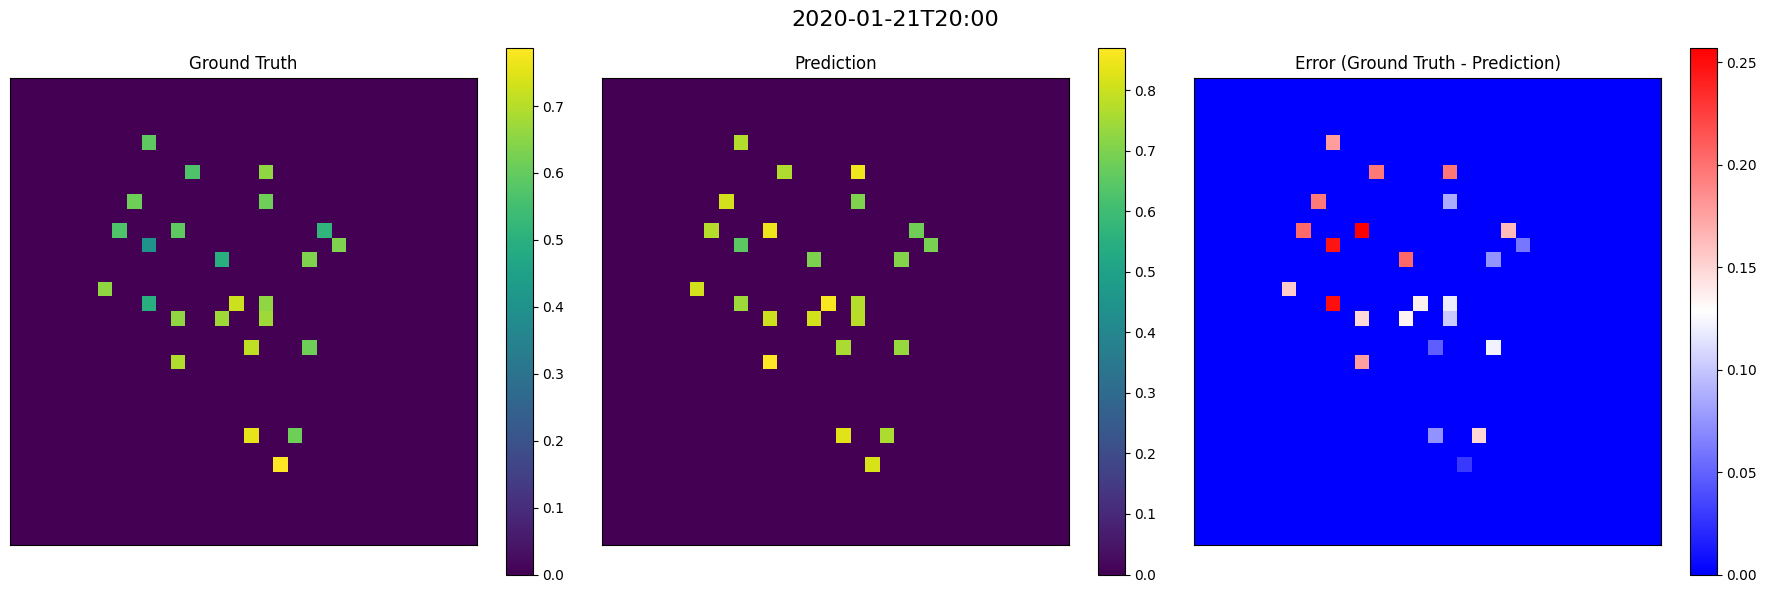

In [30]:
# train prediction 시각화
pred = predict(model=trained_model, data_loader = train_loader)
plot_ozone_maps(index=500, g_data=ytrain, prediction = pred)

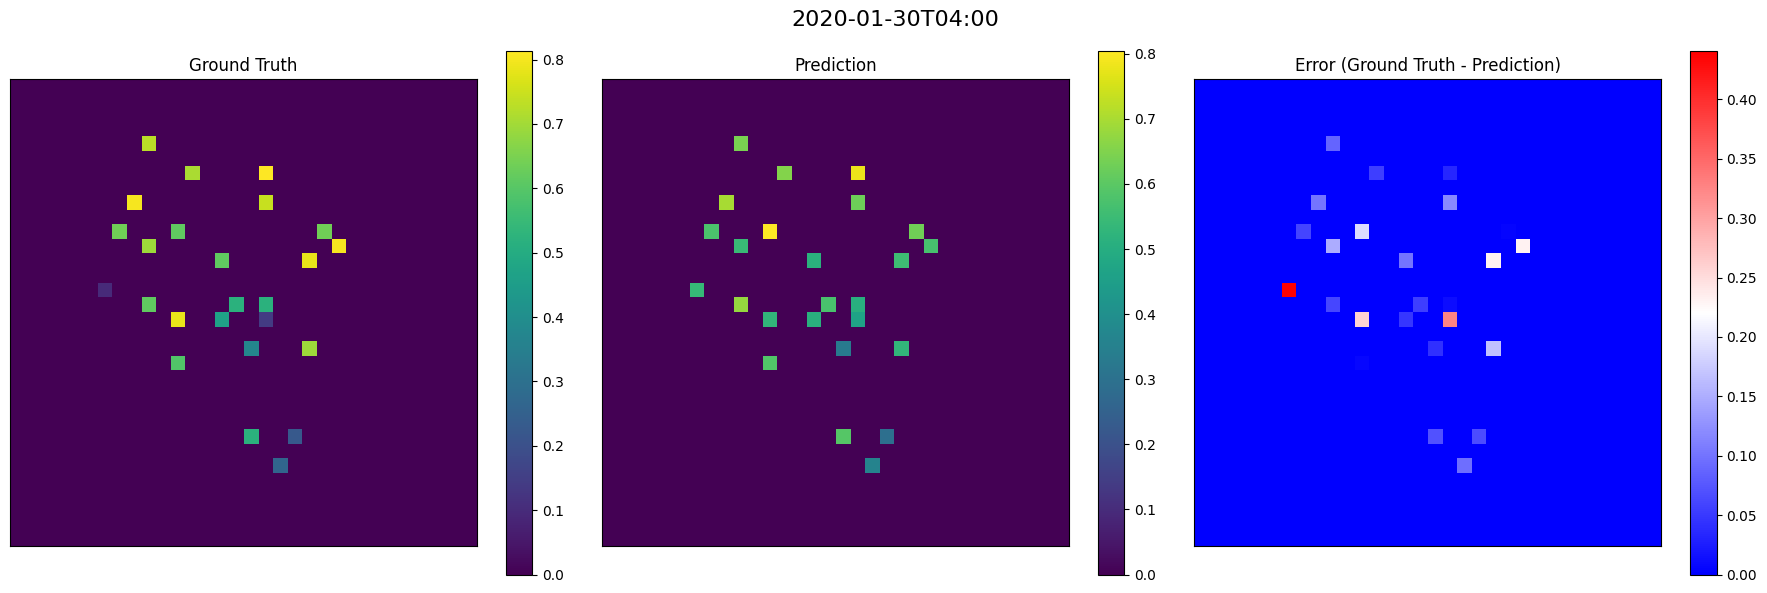

In [29]:
# test prediction 시각화
pred = predict(model=trained_model, data_loader = test_loader)
plot_ozone_maps(index=700, g_data=ytest, prediction=pred)

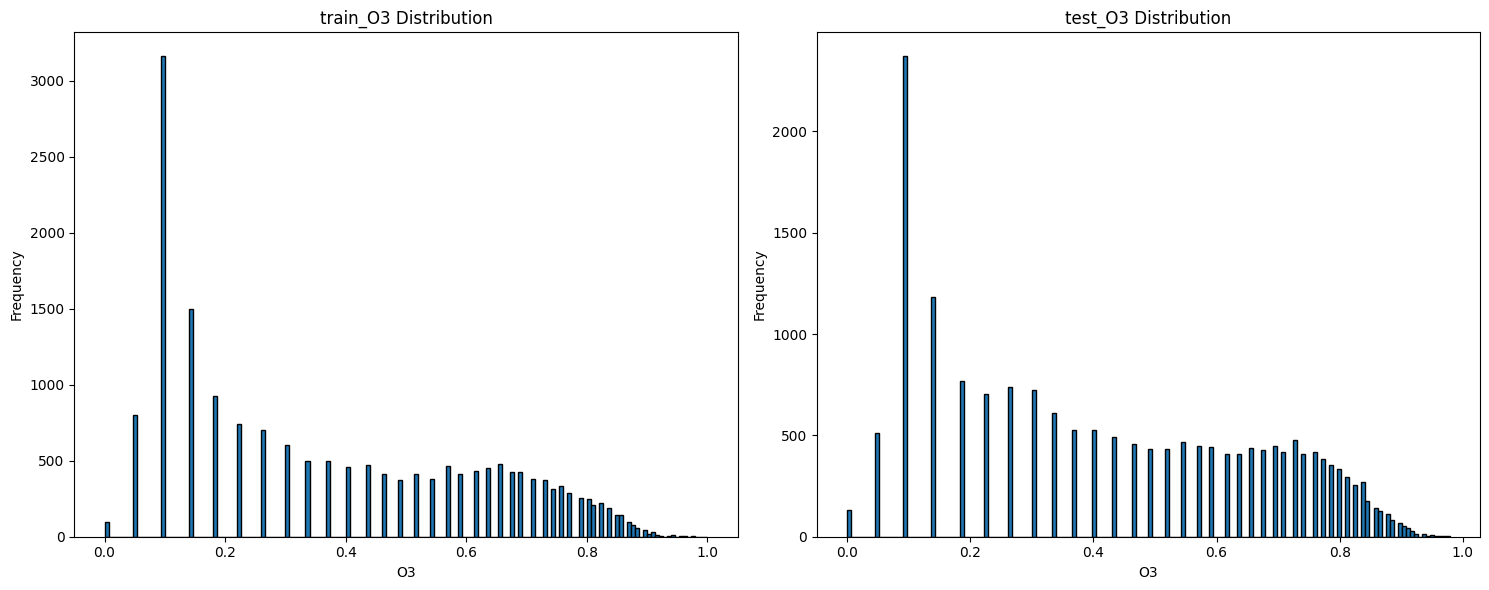

In [33]:
import matplotlib.pyplot as plt

# 서브플롯 생성 (1행 2열)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 첫 번째 히스토그램 그리기
air_quality_data['오존(ppm)'].hist(ax=axes[0], bins=150, edgecolor='black')
axes[0].set_title('train_O3 Distribution')
axes[0].set_xlabel('O3')
axes[0].set_ylabel('Frequency')
axes[0].grid(False)

# 두 번째 히스토그램 그리기
te_air_quality_data['오존(ppm)'].hist(ax=axes[1], bins=150, edgecolor='black')
axes[1].set_title('test_O3 Distribution')
axes[1].set_xlabel('O3')
axes[1].set_ylabel('Frequency')
axes[1].grid(False)

# 그래프 간격 조정 (선택 사항)
plt.tight_layout()

# 그래프 표시
plt.show()